In [79]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import XGBRegressor
from xgboost import XGBRegressor
# import GridSearchCV
from sklearn.model_selection import GridSearchCV
# import mean_absolute_error
from sklearn.metrics import mean_absolute_error
# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D

# load model
from keras.models import load_model

# pickle
import pickle

# import datatime
from datetime import datetime

# LinearRegression
from sklearn.linear_model import LinearRegression

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# mtick
import matplotlib.ticker as mtick

In [47]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_drop.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "자동차용 경유 가격 (원)" 만 사용
df = df[['자동차용 경유 가격 (원)']]
# "자동차용 경유 가격 (원)" 컬럼의 이름을 "경유 가격"으로 변경
df = df.rename(columns={'자동차용 경유 가격 (원)':'경유 가격'})
df

,경유 가격
거래년월일,
2000-01-03,583.35
2000-01-04,583.35
2000-01-05,583.35
2000-01-06,583.35
2000-01-07,583.35
...,...
2022-11-24,1879.15
2022-11-25,1879.15
2022-11-28,1879.15


In [48]:
# "경유 가격"의 이동평균을 함수로 만든다
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean()
    return df

# "경유 가격"의 이동평균을 만든다
df = make_ma(df, '경유 가격', [5, 10, 20, 60, 300])

# 컬럼의 결측치를 제거한다
df = df.dropna()
df

,경유 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2001-01-10,660.99,660.99,665.284,673.8720,682.983333,614.566967
2001-01-11,660.99,660.99,663.137,672.7985,682.463500,614.825767
2001-01-12,660.99,660.99,660.990,671.7250,681.981667,615.084567
2001-01-13,660.99,660.99,660.990,670.6515,681.499833,615.343367
2001-01-15,660.99,660.99,660.990,669.5780,681.018000,615.602167
...,...,...,...,...,...,...
2022-11-24,1879.15,1879.15,1879.150,1875.0690,1857.084833,1751.874433
2022-11-25,1879.15,1879.15,1879.150,1877.1095,1856.915500,1753.336467
2022-11-28,1879.15,1879.15,1879.150,1879.1500,1856.746167,1754.798500


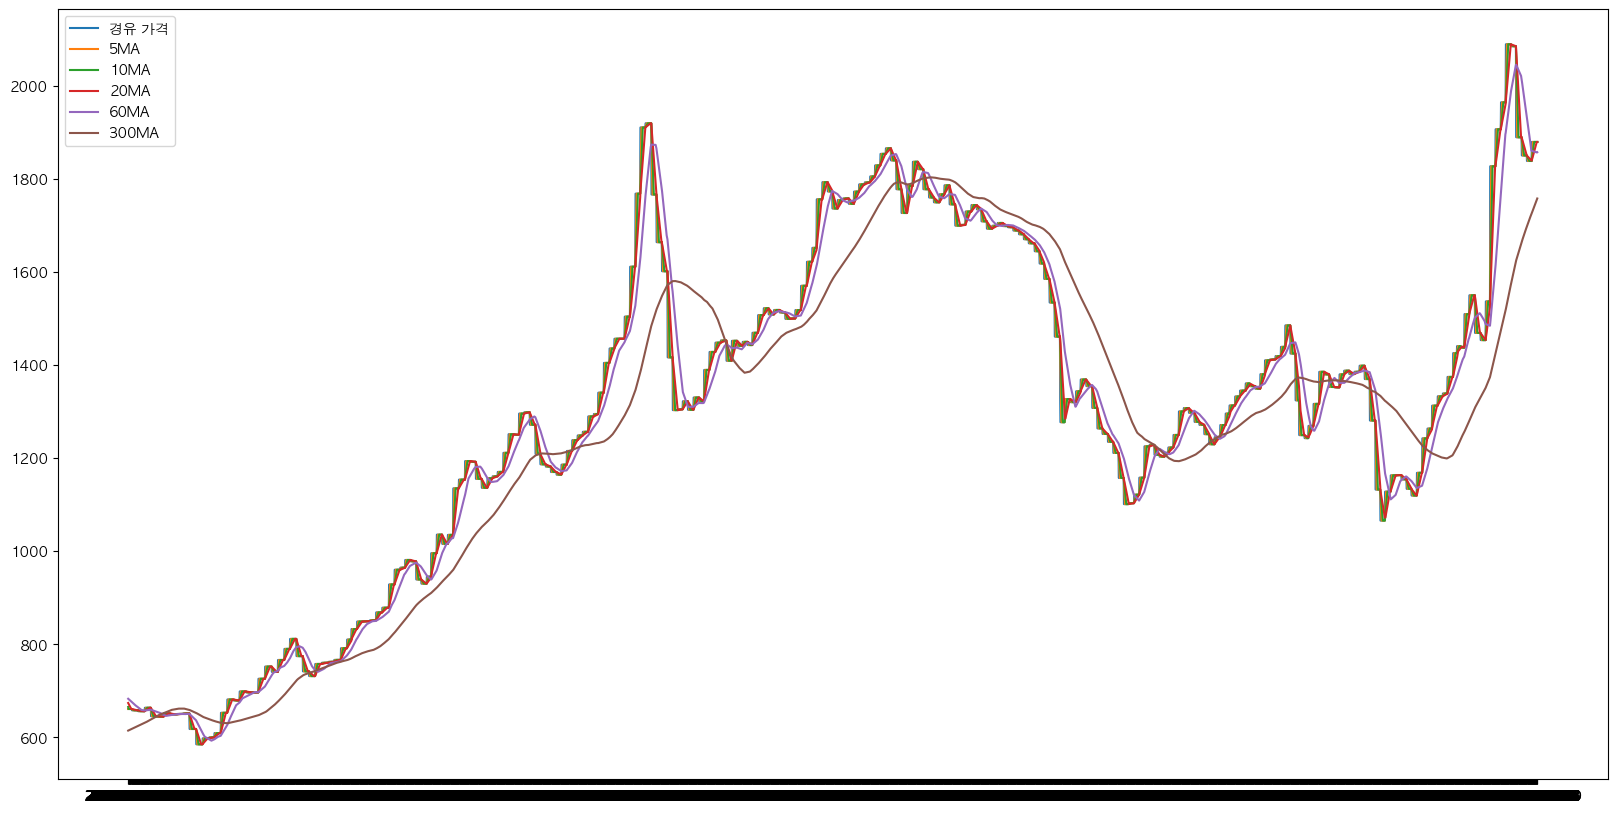

In [49]:
# "경유 가격"의 이동평균을 그래프로 확인한다
plt.figure(figsize=(20, 10))
plt.plot(df['경유 가격'], label='경유 가격')
plt.plot(df['경유 가격_5MA'], label='5MA')
plt.plot(df['경유 가격_10MA'], label='10MA')
plt.plot(df['경유 가격_20MA'], label='20MA')
plt.plot(df['경유 가격_60MA'], label='60MA')
plt.plot(df['경유 가격_300MA'], label='300MA')
plt.legend()
plt.show()


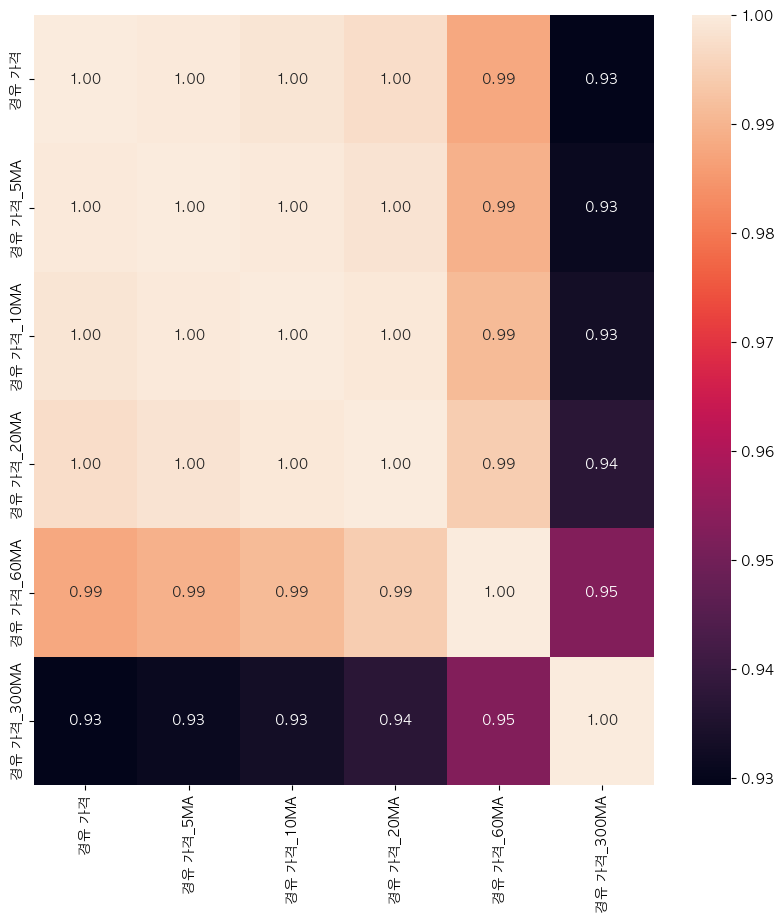

In [50]:
# 상관관계를 확인한다
df.corr()

# 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

In [51]:
# 2022-11-01 을 기준으로 df를 나눈다
df_train = df[df.index < '2021-01-01']
df_test = df[df.index >= '2021-01-01']

In [52]:
# "경유 가격" 이외에 컬럼을 사용하여 "경유 가격"을 예측한다
# "경유 가격_5MA", "경유 가격_10MA", "경유 가격_20MA", "경유 가격_60MA", "경유 가격_300MA" 컬럼을 X, "경유 가격" 컬럼을 y로 설정한다
X_train = df_train.drop('경유 가격', axis=1)
y_train = df_train['경유 가격']
X_test = df_test.drop('경유 가격', axis=1)
y_test = df_test['경유 가격']

In [53]:
#  데이터 전처리
# 데이터를 0과 1사이의 값으로 변환한다
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.7}
최고 예측 정확도: 0.2111


In [66]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(X_train, y_train)


XGBoost 모델의 RMSE: 132.56454279105537


In [80]:
# XGBoost 모델을 평가한다
y_pred = xgb.predict(X_test)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost 모델의 RMSE: 132.56454279105537


In [72]:
# 예측 성능 평가 지표를 출력한다
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MAE: 106.90210602896555
MSE: 17573.358005401555
RMSE: 132.56454279105537
R2: 0.7635117389621636


In [56]:
# 모델 저장
# 모델을 저장한다 model/
pickle.dump(xgb, open('model/xgb_oil.pkl', 'wb'))

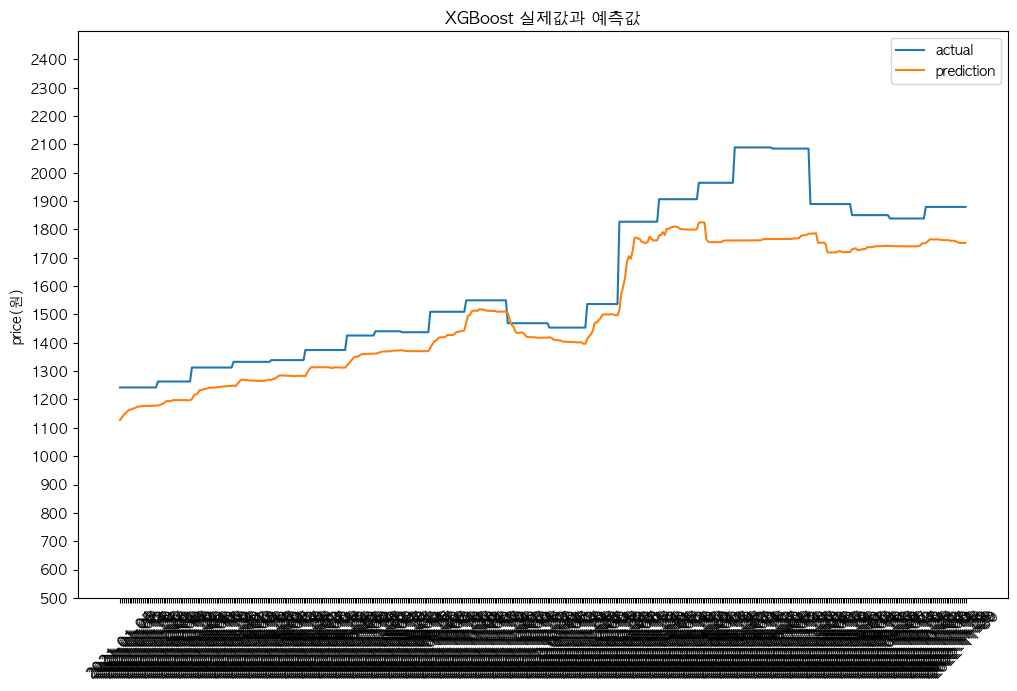

In [73]:

# XGBoost 모델의 예측 결과를 시각화한다 
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='actual')
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
# 글자 겹침을 방지하기 위해 하단에 간격을 둔다
plt.subplots_adjust(bottom=0.25)
plt.plot(y_pred, label='prediction')
plt.title('XGBoost 실제값과 예측값')
plt.ylim(500, 2500)
# y축의 눈금을 0부터 40000까지 1000 단위로 설정한다
plt.yticks(np.arange(500, 2500, 100))
# y축 눈금 라벨을 원 단위로 설정한다
plt.ylabel('price(원)')
plt.legend()
plt.show()

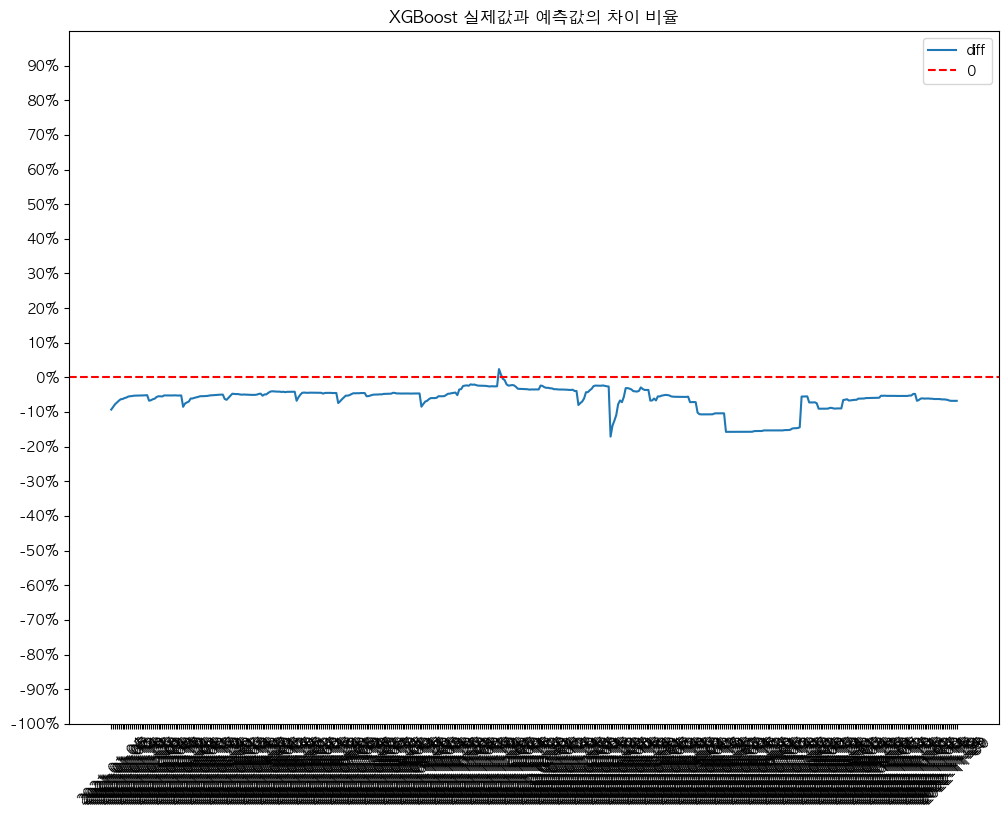

In [81]:
# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()

In [83]:
# 예측값과 실제값의 차이의 비율을 ratio에 저장한다
ratio = diff

# add_price 값을 구하는 모델을 학습한다
# 학습 데이터를 준비한다
X = ratio.values.reshape(-1, 1)
y = y_pred - y_test

# 선형 회귀 모델을 학습한다
lr = LinearRegression()
lr.fit(X, y)

# add_price 값을 예측한다
add_price = lr.predict([[0]])

# add_price 값을 출력한다
print('add_price:', add_price)

# add_price 값을 구하는 모델을 저장한다
pickle.dump(lr, open('model/lr_oil.pkl', 'wb'))

# add_price 값을 구하는 모델을 로드한다
lr = pickle.load(open('model/lr_oil.pkl', 'rb'))

# add_price 값을 예측한다
add_price = lr.predict([[0]])

# add_price 값을 출력한다
print('add_price:', add_price)


# ratio의 값이 0에 많이 분포 될 수 있도록 y_pred에 add_price 값을 더한다
y_pred = y_pred + add_price



add_price: [31.28272426]
add_price: [31.28272426]


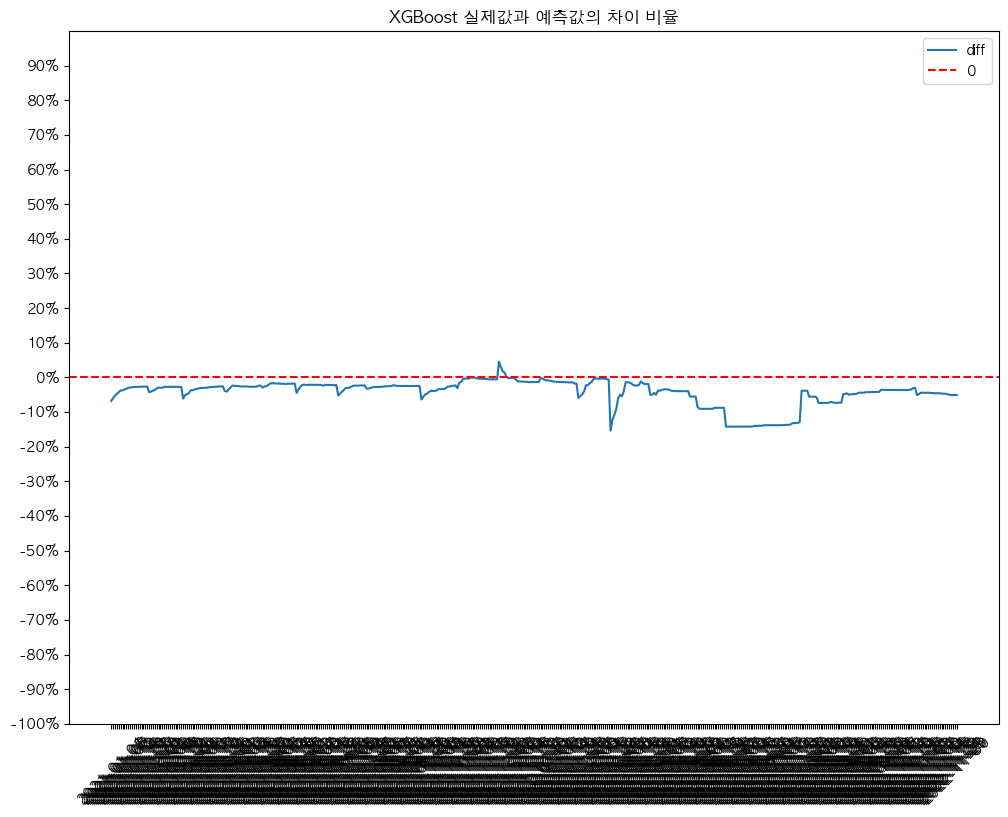

In [84]:
# ratio의 값이 0에 많이 분포 될 수 있도록 y_pred에 add_price 값을 더한다
y_pred = y_pred + add_price

# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()






In [86]:
#  예측값을 데이터프레임에 저장한다
df_pred = pd.DataFrame(y_pred, columns=['경유 예측 가격'], index=df_test.index)

df_pred

,경유 예측 가격
거래년월일,
2021-01-04,1158.324228
2021-01-05,1167.552256
2021-01-06,1177.293100
2021-01-07,1183.857553
2021-01-08,1189.978403
...,...
2022-11-24,1785.263803
2022-11-25,1783.450327
2022-11-28,1783.450327
